In [11]:
import cv2
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tensorflow import keras
from tensorflow.python.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import *

Ipy magics to reload new functions from utils

In [2]:
%load_ext autoreload
%autoreload 2

As keras kategorical output doesn't like to output doesn't like when numbers arnt starting from 0.
Make a new dictionary that starts from zero

In [3]:
by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}
by_merge_map_new = {}
poplist = []

for k in by_merge_map.keys():
    if k >= 10 and k <= 35:
        by_merge_map_new[k-10] = by_merge_map[k]


Use get root path to find the project root.
Then locate the csvs with the data for the project.

In [ ]:
root_path, data_path = get_root_path('mnist_portfolio')

paths = data_path.glob('*.csv')

Filter the paths to generate then read the filtered files.
Sets all values < 150 to 0. And offsets the y labels with -10

In [4]:
for p in paths:
    if 'Rensade' in str(p):
        x_train, y_train = gen_sets(p)
x_train[x_train < 150] = 0
y_train = y_train - 10

Looks at the distribution of labels in the training dataset

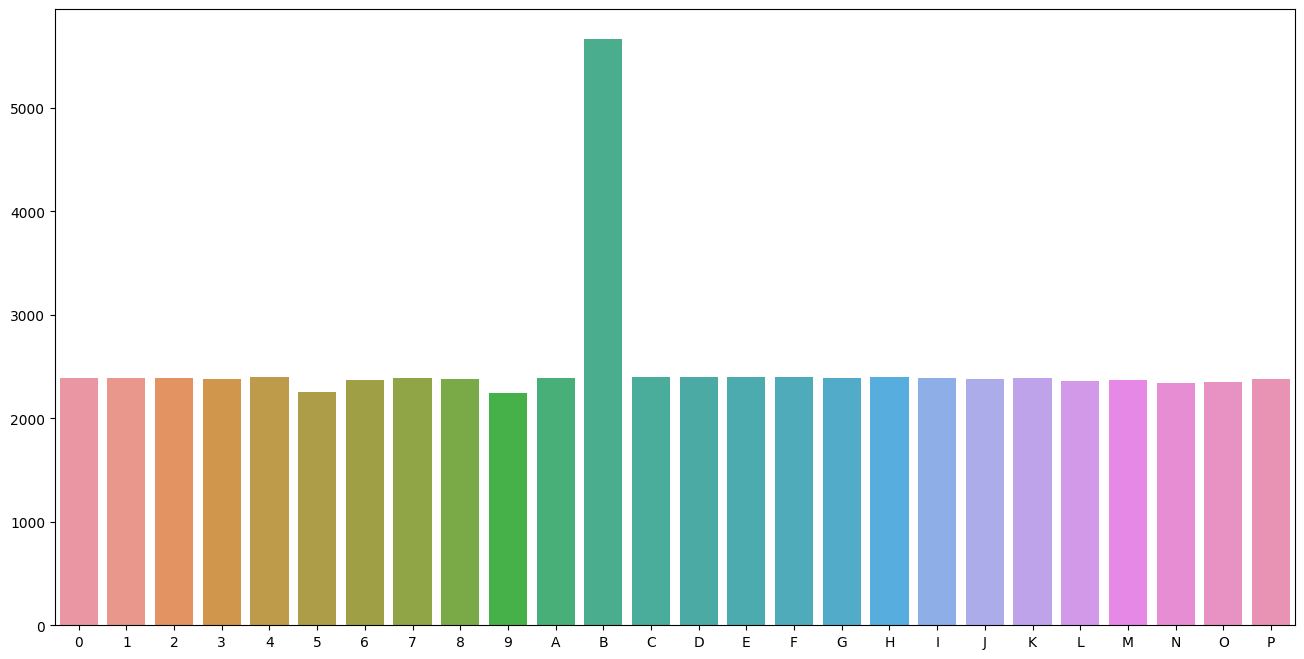

In [6]:
plt.figure(figsize=(16, 8)) 
unique_bar(y_train, by_merge_map)

Preprocess the data by removing empyt edges, the fills the picture so it gets squared.
Then it reshapes the picture to 28, 28

In [8]:
no = 0
last = len(x_train)
for i, x in enumerate(x_train):
    if i%100 == 0:print(f'{i}/{last}')
    x_train[i]= fix_image(x_train[i], 2).reshape(28,28)

0/65017
100/65017
200/65017
300/65017
400/65017
500/65017
600/65017
700/65017
800/65017
900/65017
1000/65017
1100/65017
1200/65017
1300/65017
1400/65017
1500/65017
1600/65017
1700/65017
1800/65017
1900/65017
2000/65017
2100/65017
2200/65017
2300/65017
2400/65017
2500/65017
2600/65017
2700/65017
2800/65017
2900/65017
3000/65017
3100/65017
3200/65017
3300/65017
3400/65017
3500/65017
3600/65017
3700/65017
3800/65017
3900/65017
4000/65017
4100/65017
4200/65017
4300/65017
4400/65017
4500/65017
4600/65017
4700/65017
4800/65017
4900/65017
5000/65017
5100/65017
5200/65017
5300/65017
5400/65017
5500/65017
5600/65017
5700/65017
5800/65017
5900/65017
6000/65017
6100/65017
6200/65017
6300/65017
6400/65017
6500/65017
6600/65017
6700/65017
6800/65017
6900/65017
7000/65017
7100/65017
7200/65017
7300/65017
7400/65017
7500/65017
7600/65017
7700/65017
7800/65017
7900/65017
8000/65017
8100/65017
8200/65017
8300/65017
8400/65017
8500/65017
8600/65017
8700/65017
8800/65017
8900/65017
9000/65017
9100/65017


Takes 100 random samples from the training data to display.

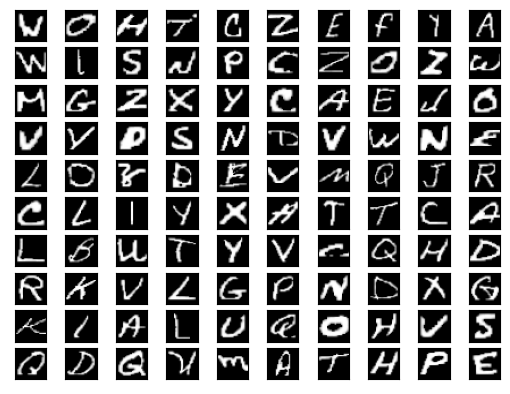

In [9]:
for i, r in enumerate(np.random.randint(0, len(x_train), 100)):
    
    plt.subplot(10,10,i+1)
    plt.imshow(x_train[r], cmap='gray')
    plt.xticks([]), plt.yticks([])

The mean picture for the training dataset

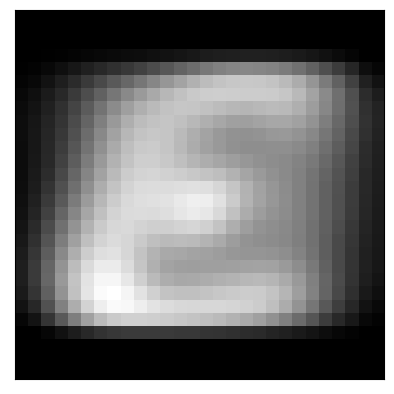

In [63]:
plt.xticks([]), plt.yticks([])
plt.imshow(np.mean(x_train, axis=0), cmap='gray')

### Modeling


Extra cell if needed to run to reshape the data if cells needs to get rerun

In [65]:
x_train = np.asarray(x_train.reshape(65017, 28, 28))

Extracts number of classes, input shapes for the model.

Changes datatype of the training data to float and divides by 255 to make it go from 0 - 1
Also one hot encodes the the classes.

In [15]:
num_classes = len(np.unique(y_train))
input_shape = (28, 28, 1)

x_train = x_train.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)

y_train = keras.utils.to_categorical(y_train.ravel(), num_classes)

Splits the training dataset to get a testset to validate against.

In [16]:
x_train1, x_test, y_train1, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=215)

Create the cnn model.

with blocks of 2 conv2d layers with the same amount of filter and kernels.
Followed by a pooling layer to downsample the information. 
The following batchnormalization usually gets the learning rates higher and speeds up the training.

This principle is copied then it flattens to a dense layer with 512 fully connected nodes that finally is connected to the output.

In [68]:
# Building model

model=keras.Sequential(

[
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
        
    tf.keras.layers.Dense(num_classes,activation="softmax")
    ])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

To get a more robust model picture augmentation is used. Where the picture gets rotated 15 degrees. The zoom shifts and the width and height also gets shifted.

In [70]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_gen = datagen.flow(x_train, y_train, batch_size=128)
test_gen = datagen.flow(x_test, y_test, batch_size=128)

Training configuration is made.
With set amount of epoch and batchsize that decides on how many samples is put through each trainging batch.

early stopping is used to stop if the model stops making progress on the validation accuracy.
To properly settle down in the current local minima an fucntion to reduce the learningrate is used.

In [71]:
epochs = 100
batch_size = 128
train_steps = x_train.shape[0] // batch_size
valid_steps = x_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

Train model with set configruation

In [72]:
history = model.fit(train_gen, 
                    epochs = epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = test_gen,
                    validation_steps = valid_steps, 
                    callbacks=[es, rp])

Epoch 1/100
507/507 [==============================] - 37s 71ms/step - loss: 0.4081 - accuracy: 0.8802 - val_loss: 0.3914 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 2/100
507/507 [==============================] - 37s 74ms/step - loss: 0.1909 - accuracy: 0.9438 - val_loss: 0.2308 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 3/100
507/507 [==============================] - 37s 72ms/step - loss: 0.1585 - accuracy: 0.9532 - val_loss: 0.1380 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 4/100
507/507 [==============================] - 37s 74ms/step - loss: 0.1371 - accuracy: 0.9594 - val_loss: 0.1290 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 5/100
507/507 [==============================] - 39s 77ms/step - loss: 0.1263 - accuracy: 0.9621 - val_loss: 0.1493 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 6/100
507/507 [==============================] - 40s 79ms/step - loss: 0.1206 - accuracy: 0.9632 - val_loss: 0.1216 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 7/100
507/507 [==============================]

Tests the model on the split validation data.

In [73]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.01130805816501379
Test accuracy: 0.9963088035583496


Saves the model

In [74]:
save_time = str(datetime.datetime.now()).rsplit('.')[0].replace('-', '_').replace(' ', '_')
model.save(f'./model/2emnist_save.h5')

Loads the model and verifys it saves and loads properly

In [17]:
m2 = keras.models.load_model('./model/2emnist_save.h5')
m2.evaluate(x_test, y_test, verbose=0)

[0.011308044195175171, 0.9963088035583496]

Make predictions for confusion matrix and classification report

In [18]:
y_pred = m2.predict(x_test)

407/407 [==============================] - 5s 13ms/step


Results

<AxesSubplot: >

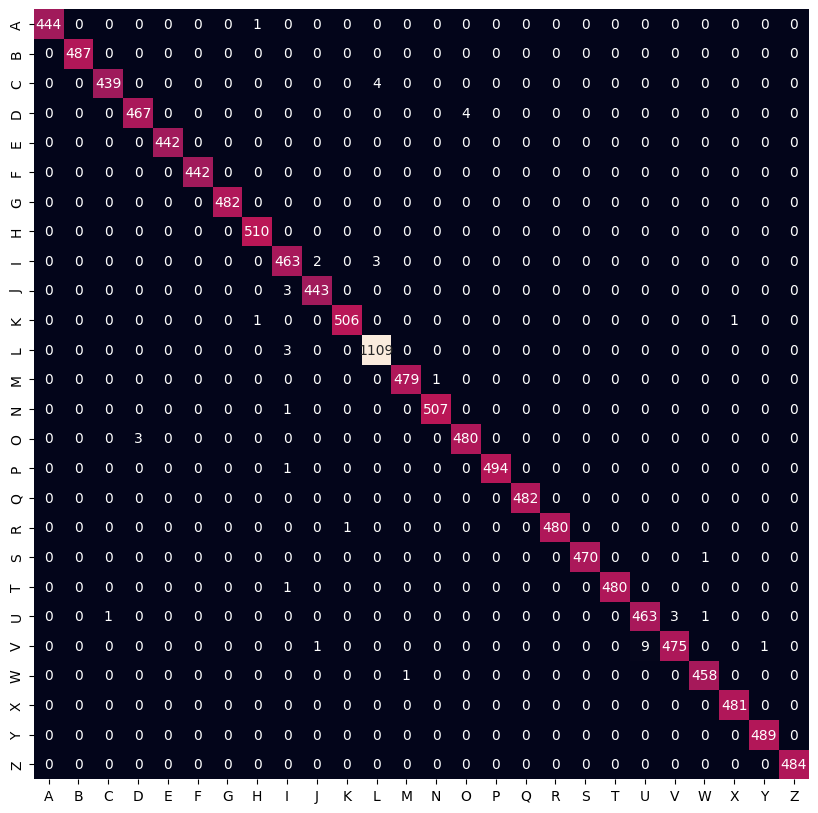

In [19]:

plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, vmin=np.min(cm), vmax=np.max(cm), annot=True, cbar=False ,fmt='d', xticklabels=by_merge_map_new.values(), yticklabels=by_merge_map_new.values())

In [20]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1),target_names=by_merge_map_new.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       445
           B       1.00      1.00      1.00       487
           C       1.00      0.99      0.99       443
           D       0.99      0.99      0.99       471
           E       1.00      1.00      1.00       442
           F       1.00      1.00      1.00       442
           G       1.00      1.00      1.00       482
           H       1.00      1.00      1.00       510
           I       0.98      0.99      0.99       468
           J       0.99      0.99      0.99       446
           K       1.00      1.00      1.00       508
           L       0.99      1.00      1.00      1112
           M       1.00      1.00      1.00       480
           N       1.00      1.00      1.00       508
           O       0.99      0.99      0.99       483
           P       1.00      1.00      1.00       495
           Q       1.00      1.00      1.00       482
           R       1.00    